# Análisis exploratorio de datos
Basado en Hair et AI. (2013), capítulo 'Examining your data', vamos a proceder con los siguientes pasos

* **1. Entender el problema:** Mirar cada variable y su relevancia para resolver el problema
* **2. Análisis univariante:** realizado sobre la variable target (SalesPrice)
* **3. Análisis multiunivariante:** para obtener variables dependientes e independientes
* **4. Limpieza de datos:** detectar NAs, outliers y variables categóricas
* **5. Transformación de datos:** aplicando análisis multivariante, vamos a tener que 
    - Normalizar datos: hacer que sigan una distribucióon normal (dado que luego cuando usemos algunos análisis estadísticos, si no lo siguen nos saldrán mal). Lo haremos solo respecto a la variable target y si tenemos pocos datos, dado que este punto para grandes volumenes de datos no suele ser un problema
    - Heterocedasticidad: para asegurar que un error no es constante para todas las variables independientes
    - Linealidad
    - Asegurar que no hay errores correlacionados

* **6. Conclusiones** 

---


## 1. Entender el problema

Realizamos Importación de librerías y ficheros 

In [1]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importación de ficheros
df_train = pd.read_csv('data/PreciosCasas/train.csv')
print (df_train.describe())
df_train.columns


                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Como se puede observar, hemos importado 1460 registros distintos, y disponemos de varias variables para determinar el precio de las casas
Tenemos de variables numéricas y categóricas, además, para empezar el análisis vamos a:
* seleccionar aquellas que por lógica, nos parece que guardarán más relación con la variable target (SalesPrice). Por ejemplo, si el tener o no garaje puede encarecer un piso (que parece indicar que si), o
* y que variables a priori, parecen relacionadas entre sí. Por ejemplo, hasta que punto necesito LandScope, que me indica ya la inclinación de la propiedad, si tengo ya LandContour

A priori, suponemos que las siguientes variables son importantes: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea, Neigborhood

y analicemos entonces la **variable target**. Se ve el los resultados anteriores ( o por ``df_train['SalePrice'].describe()`` ) que sí tenemos datos para las 1460 variables, que el mínimo es mayor que cero (y por lo tanto, sí hay información) y que además se distribuye siguiendo una distribución normal con asimetría positiva (possitive skewness), es decir, son sesgo en valores superiores a la media (tenemos propiedades cuyo precio es muy superior al de la mayoría), y con los valores concentrados en la región central de la distribución (curtosis > D. normal). 
**Podemos por tanto continuar el análisis para predicción de esa variable **

Skewness: 1.882876
Kurtosis: 6.536282


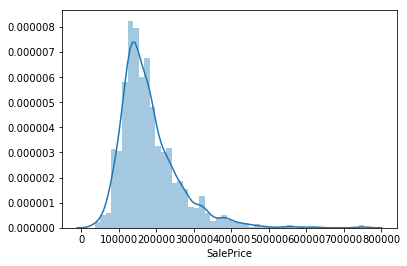

In [2]:
#histograma
sns.distplot(df_train['SalePrice']);

# Valor de la asimetría y curtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

## 2. Análisis univariante 
¿Qué relación hay entre el target y el resto de variables?

Hemos dicho que íbamos a seleccionar ciertas variables, veamos como se relacionan con la target

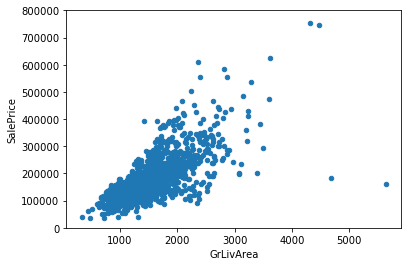

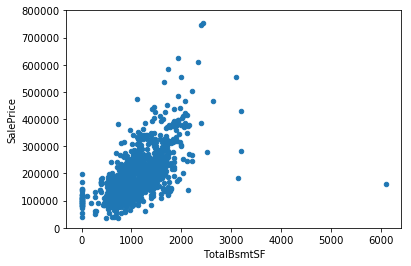

In [3]:
# 1) scatter plot entre grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

# 2) scatter plot entre totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

***Variables numéricas***

Parece haber una relación lineal con grlivarea y menos lineal con totalbsmtsf (de hecho, lineal hasta cierto punto y luego parece exponencial)

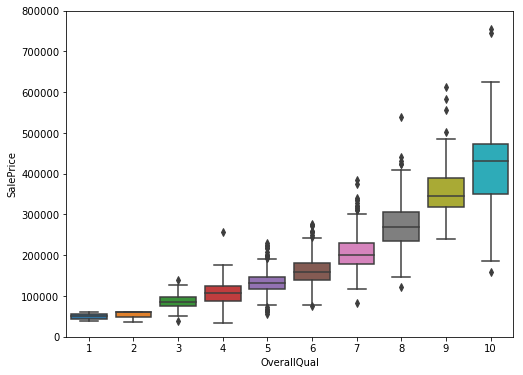

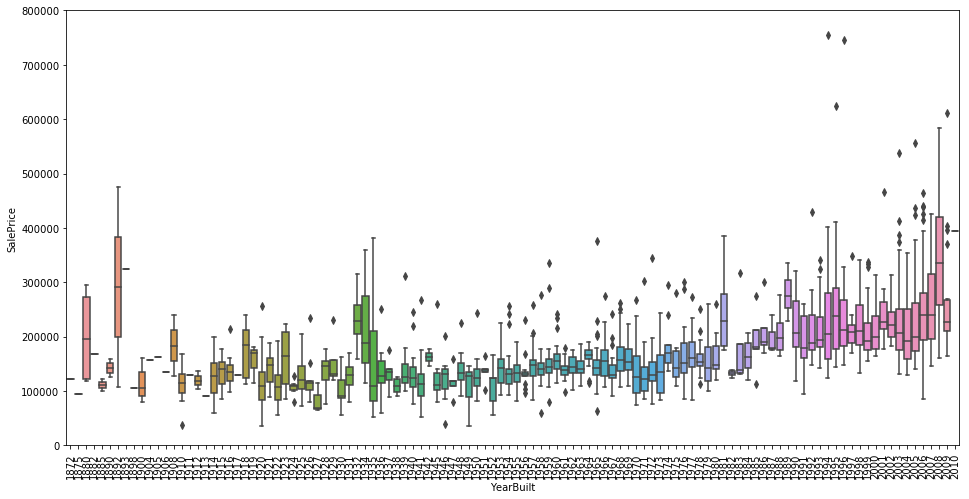

In [4]:
#1) box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

#1) box plot YearBuilt/saleprice
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);


***Variables Categóricas***

De nuevo sí, hay relación entre OverallQual, la calidad de la casa y el precio, por un lado, y sorprendentemente, no tan lineal con el YearBuilt, pues parece que un poco sí cuestan más las casas más nuevas... pero no del todo. Aquí sería interesante saber hasta que punto el efecto de la inflación se ha tenido en cuenta y cuan comparables son los precios a lo largo de los años, en cualqueir caso, para eso tenemos el año de venta y se analizará en el multivariante

---

## 3. Análisis multivariante
Las variables anteriores se han seleccionado por lógiva, pero no podemos estar seguros de que son todas correctas, lo óptimo es establecer una matriz de correlación a ver que variables resultan significativas, cuales no y su nivel de relación con la target

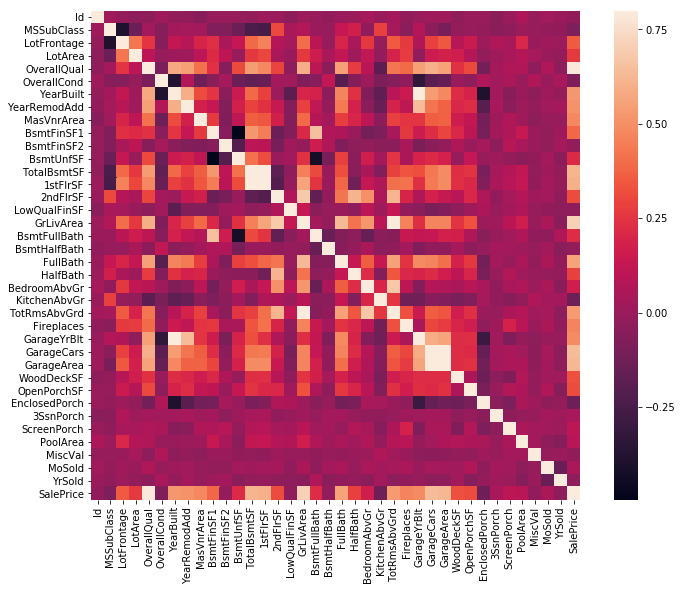

In [5]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Llama la atención los dos cuadrados más claritos, los que relacionan 'TotalBsmtSF' y '1stFlrSF' y todos los de 'Garage...' , y claro, tiene sentido, seguramente es que están correlacionadas (y no debemos usarlas a la vez, pues proporcionarán luego "ruido" al modelo).


Por otro lado, analizando la línea de la target, SalesPrice, vemos que en efecto, las variables antes seleccionadas por lógica 'GrLivArea', 'TotalBsmtSF' y 'OverallQual', están bien correlacionadas con la target.
Contabilicemos cuanto

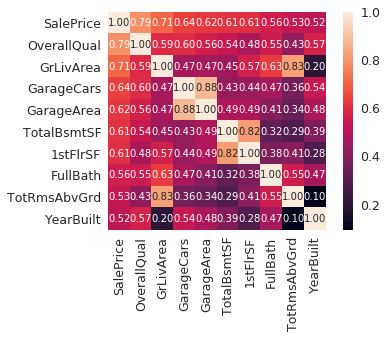

In [6]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Seleccionaremos estas variables
- 'OverallQual'
- 'GrLivArea'
- 'GarageCars' y 'GarageArea' también, pero como están correlacionadas entre ellas, elegimos solo 'GarageCars' (la de correlación mayor).
- 'TotalBsmtSF' y '1stFloor' Lo mismo. Seleccionamos 'TotalBsmtSF'
- 'FullBath'
- 'TotRmsAbvGrd' y 'GrLivArea' Lo mismo. Seleccionamos 'GrLivArea'
- 'YearBuilt' también, aunque hemos visto antes que podía ser rara

Vamos a ver su distribución

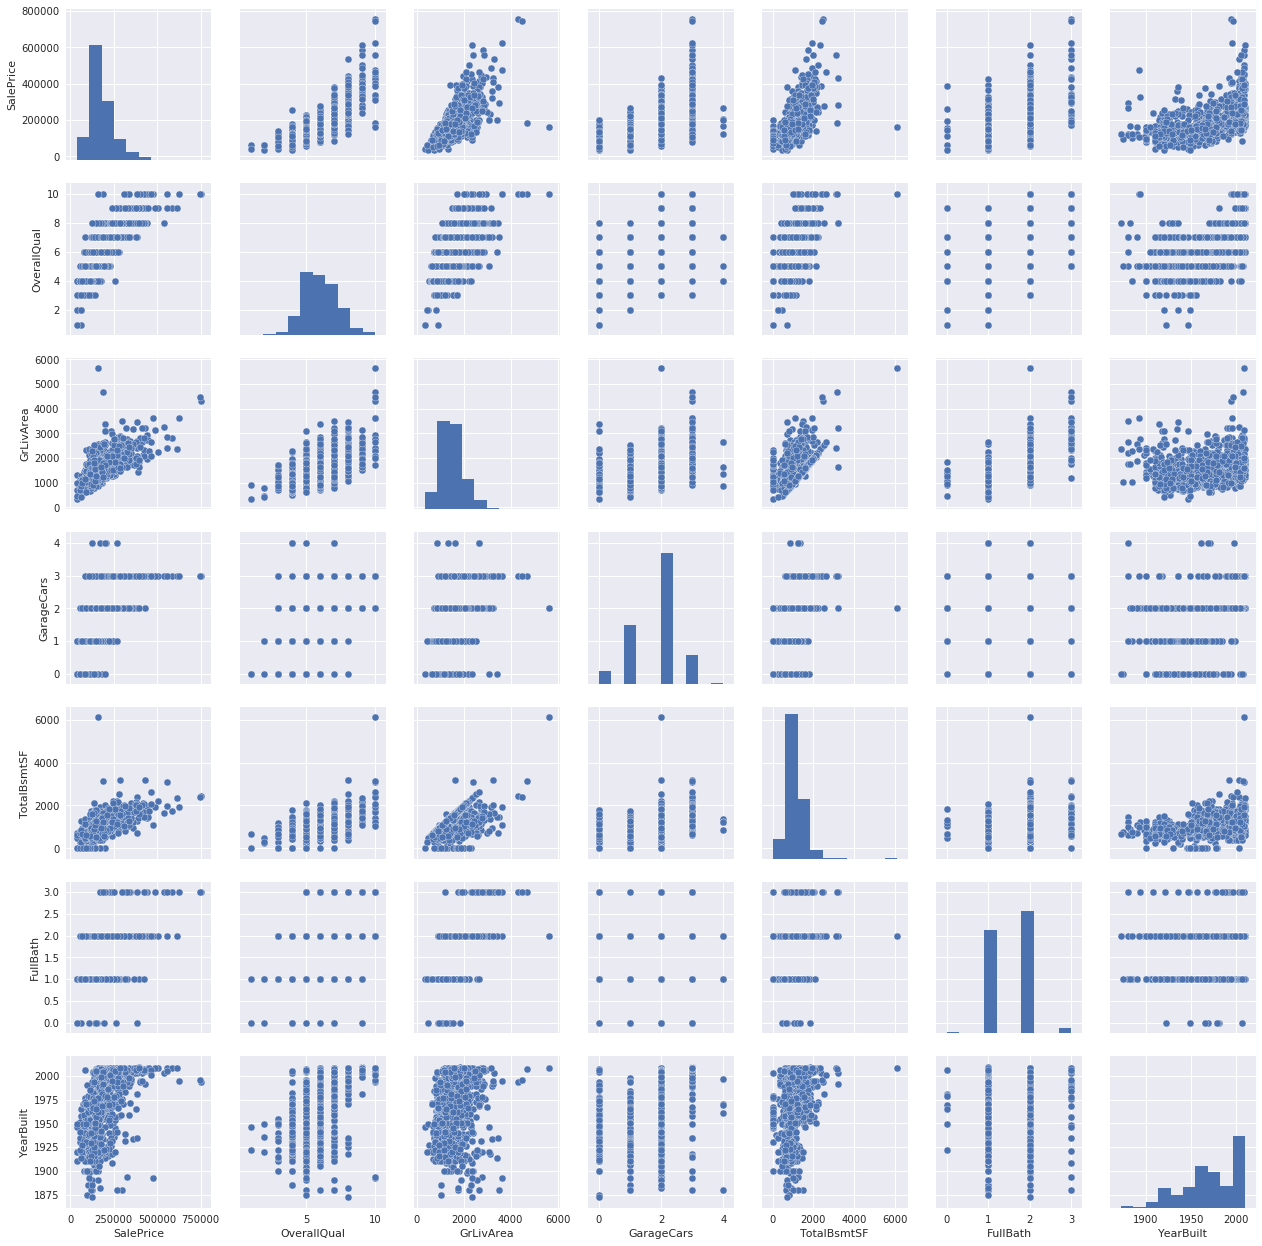

In [7]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

Vemos que 'TotalBsmtSF' y 'GrLiveArea' dibujan prácticamente una linea y el resto de puntos van por debajo... claro, puedes tener garajes que ocupen toda la propiedad pero no al revés (sería absurdo)
Con 'SalePrice' y 'YearBuilt' pasa lo que adelantábamos antes, a partir de cierto año los precios crecen mucho, en cualqier caso, sigue siendo una variable a tener en cuenta

##  4. Limpieza de datos

- **Missing data**

    Este tema es muy relevante, pues ¿hasta que punto los NAs siguen un patrón aleatorio o son constantes en nuestros datos? Puede llevarnos a reducir tanto el tamaño de la muestra que hasta nos impida hacer el análisis. Pasemos pues a analizarlo y ver hasta que punto las variables que hemos visto más significativas, están completas o no


In [8]:
#missing data ordenados por %
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


*Hipótesis: un dato no es correcto si tiene más de un 15 % de NAs*

Según esto
- 'PoolQC', 'MiscFeature', 'Alley', etc no podremos considerarlas (pero no importa, no parecían relevantes tampoco, e incluso ser outliers)
- 'Garage..' lo mismo, pero como 'GarageCars' no está en la lista, sí (tendrá como máximo un 5% de los valores NAs, pero no más)
- 'MasVnrArea' y 'MasVnrType' tampoco parecían relevantes, así que bien (y mirando el mapa de calor, estabas correlacionadas con 'YearBuilt' y 'OverallQual' así que no perdemos nada)
- 'Electrical' tiene solo una observación, así que la borraremos pero sí mantendremos la variable


In [9]:
#Creación de los nuevo data frames
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

# Veamos que está bien (debe dar 0
df_train.isnull().sum().max() 

0

- **Outliars**

    Hay que definir un umbral a partir del cual definimos un dato como outliar, para lo cual necesitaremos estandarizar los datos, y analizar cuanto se desvian de 0 por encima y por debajo


In [10]:
#Estandarizar datos del target
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('Rango bajo (low) de la distribución:')
print(low_range)
print('\nRango alto (high) de la distribución')
print(high_range)

Rango bajo (low) de la distribución:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

Rango alto (high) de la distribución
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


los valores por debajo no preocupan (en torno a -1), pero los por encima si, especiamente esos de más de 7 (seguramente son outliars). Veamos estos datos en perspectiva con las dos variables más significativas o relacionadas con la target

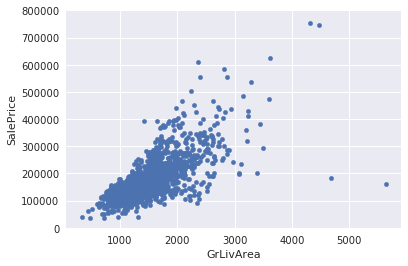

In [11]:
# saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

en efecto, tenemos dos valores que para ese tamaño de propiedad, no pega que sean tan bajos y se desvian de la tendencia, así que los quitaremos. Mantendremos sin embargo los dos valores de precio más alto, dado que SI parecen mantener esa tendencia

In [12]:
#Eliminar outliers
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

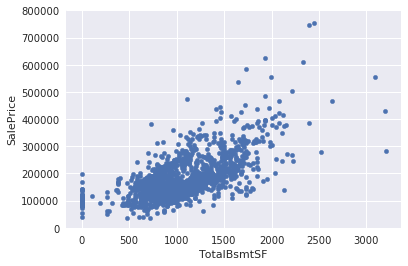

In [13]:
# saleprice/TotalBsmtSF
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Para este caso, no merece la pena quitar nada

## 5. Transformación de datos

Veamos como han quedado los datos y que distribución siguen para saber si debemos ajustarlos de alguna manera

### Normalización

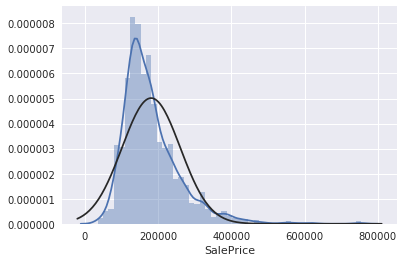

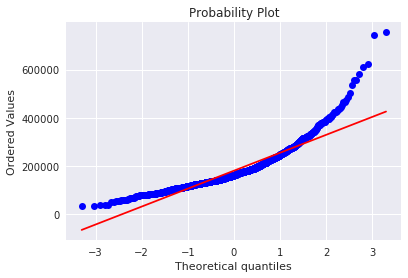

In [14]:
#histograma y normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Para casos de asimetría positiva, se puede lograr que los datos sigan una distribución normal mediante una transformación logartimica, esto es:

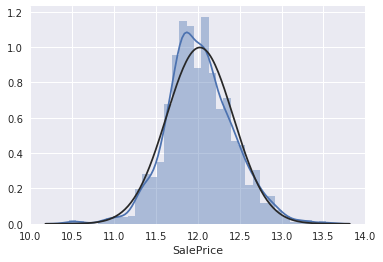

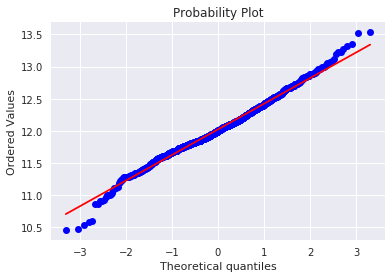

In [15]:
# transformación logarítmica
df_train_log = pd.DataFrame(df_train)
df_train_log ['SalePrice'] = np.log(df_train['SalePrice'])

# nuevo histograma y normal probability plot
sns.distplot(df_train_log['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train_log['SalePrice'], plot=plt)

Y claro, pasará lo mismo con 

    1) 'GrLivArea'
    2) 'TotalBsmtSF'

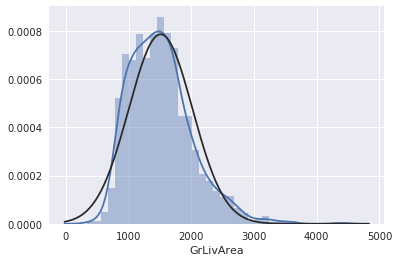

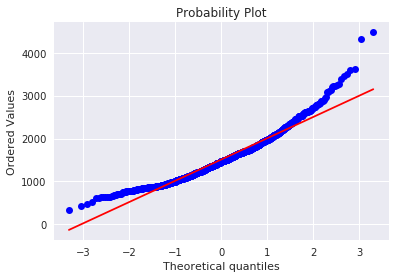

In [16]:
# 1) GrLivArea
#histograma y normal probability plot
sns.distplot(df_train_log['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train_log['GrLivArea'], plot=plt)

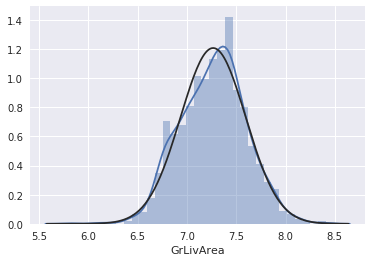

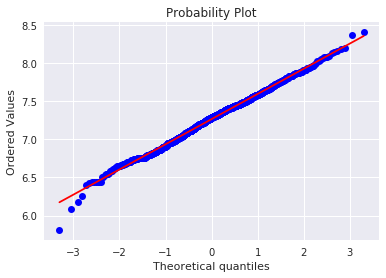

In [17]:
# transformación logaritmica
df_train_log ['GrLivArea'] = np.log(df_train_log['GrLivArea'])

#transformed histogram and normal probability plot
sns.distplot(df_train_log['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train_log['GrLivArea'], plot=plt)

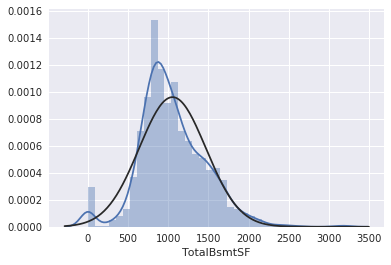

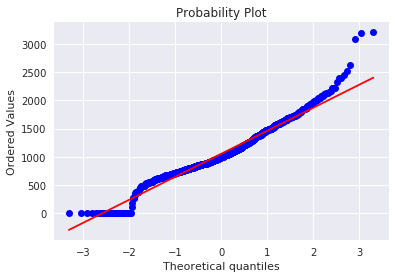

In [18]:
# 2) TotalBsmtSF
#histogram and normal probability plot
sns.distplot(df_train_log['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train_log['TotalBsmtSF'], plot=plt)

En este caso hay valores = 0, por lo tanto NO se puede aplicar logaritmos. De nuevo, hay que hacer una suposición, cuando esos ceros seguramente se refieren a que no hay sotano, así que en este caso, la teoría dice que hay que hacer una nueva variable binaria (siene sotano si/no) y luego a los que sí, aplicar ya la transformación de los datos 


In [37]:
df_train_log['ConBasement'] = 1
df_train_log['ConBasement'][df_train_log['TotalBsmtSF'] ==0] = int (0)

# Y ahora quitamos los 0 de TotalBsmtSF y hacemos el logaritmo
df_train_log2 = pd.DataFrame(df_train_log)
df_train_log2 ['TotalBsmtSF'][df_train_log['TotalBsmtSF'] ==0] = na

# transformación logaritmica
df_train_log2 ['TotalBsmtSF'] = np.log(df_train_log2['TotalBsmtSF'])

#transformed histogram and normal probability plot
sns.distplot(df_train_log2['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train_log2['TotalBsmtSF'], plot=plt)


NameError: name 'na' is not defined


### Heterocedasticidad
Lo haremos de forma gráfica: si tiene forma cónica o de diamante

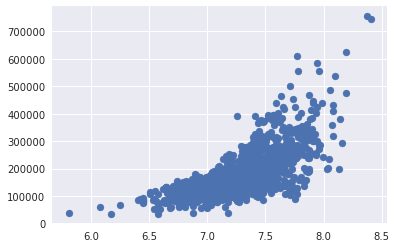

In [19]:
#scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

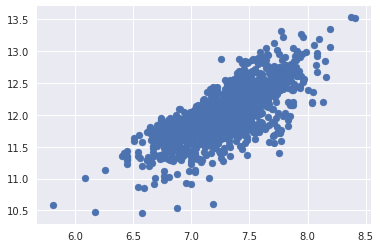

In [20]:
plt.scatter(df_train_log['GrLivArea'], df_train_log['SalePrice']);

Antes los datos tenian forma de diamante, pero tras la normalización ya no, por lo que no tenemos problemas en este punto para 'GrLivArea'

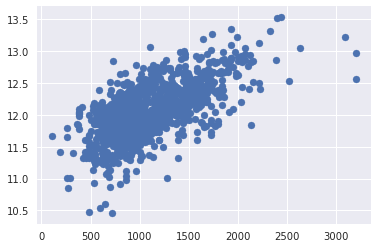

In [24]:
#scatter plot
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

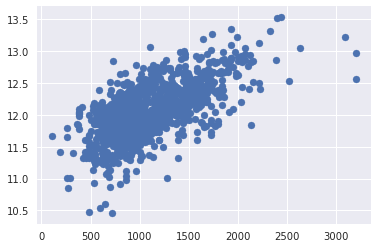

In [25]:
#scatter plot
plt.scatter(df_train_log[df_train_log['TotalBsmtSF']>0]['TotalBsmtSF'], df_train_log[df_train_log['TotalBsmtSF']>0]['SalePrice']);

en este caso igual, parece que la varianza del target respecto a TotalBsmtSF es similar en todo el rango

### Variables Dummy
Hay una función que lo hace

In [23]:
#convert categorical variable into dummy
df_train_log = pd.get_dummies(df_train_log)

## Conclusiones
Disponemos de un data frame limpio y listo para ser usado en los siguientes apartados de modelización. Subámoslo pues a nuestro repositorio para poder usarlo


In [30]:
df_train_log.to_csv('data/PreciosCasas/train_final.csv', sep='\t', encoding='utf-8')